In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils_ccd import get_connection

conn = get_connection()

In [73]:
sql_nereu = """
SELECT p.numero_processo, p.ano_processo, p.codigo_tipo_processo, p.assunto, 
r.nome, pm.Descricao as marcador, p.IdProcesso as id_processo
FROM processo.dbo.Processos p 
	INNER JOIN processo.dbo.Pro_MarcadorProcesso pmp ON p.IdProcesso = pmp.IdProcesso
	INNER JOIN processo.dbo.Pro_Marcador pm ON pm.IdMarcador = pmp.IdMarcador 
	INNER JOIN processo.dbo.Relator r ON r.codigo = p.codigo_relator 
WHERE setor_atual = 'CCD' 
	AND lower(pm.Descricao) = 'DESCONTO EM FOLHA - Nereu'
"""
processos_nereu = pd.read_sql(sql_nereu, conn)

/tmp/ipykernel_92133/2147694724.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  processos_nereu = pd.read_sql(sql_nereu, conn)


In [133]:
sql_debitos = '''  
SELECT DISTINCT 
        ed.IdDebito as id_debito,
        pro.numero_processo,
       pro.ano_processo,
       pro.assunto,
       etd.Descricao as tipo_multa,
       edmc.DataFinalImputacaoMultaCominatoria as data_final_cominatoria,
       pm.Descricao as descricao,
       CONCAT(gp.Nome, ' (CPF: ', gp.Documento, ')') as nome,
       processo.dbo.fn_Exe_RetornaValorAtualizado(ed.IdDebito) as valor_multa,
       r.nome as relator,
       ed.IdProcessoOrigem as id_processo_origem,
       (
        SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoOrigem
       ) as processo_origem,
       ed.IdProcessoExecucao as id_processo_execucao,
       (
       SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoExecucao
       ) as processo_execucao
	FROM processo.dbo.Processos pro
	INNER JOIN processo.dbo.Pro_MarcadorProcesso pmp ON pmp.IdProcesso = pro.IdProcesso
	INNER JOIN processo.dbo.Pro_Marcador pm ON pmp.IdMarcador = pm.IdMarcador
	INNER JOIN processo.dbo.Relator r ON r.codigo = pro.codigo_relator 
	LEFT JOIN processo.dbo.Exe_Debito ed ON ed.IdProcessoExecucao = pro.IdProcesso
	LEFT JOIN processo.dbo.Exe_DebitoPessoa edp ON edp.IDDebito = ed.IdDebito
	LEFT JOIN processo.dbo.Exe_TipoDebito etd ON etd.CodigoTipoDebito = ed.CodigoTipoDebito
	LEFT JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = edp.IDPessoa
	LEFT JOIN processo.dbo.Exe_Debito_MultaCominatoria edmc ON ed.IdDebito = edmc.IdDebito
	WHERE pro.setor_atual = 'CCD'
	AND pm.Descricao = 'DESCONTO EM FOLHA - Nereu'
	AND ed.CodigoStatusDivida = 1
'''

debitos = pd.read_sql(sql_debitos, conn)

debitos['id_processo_origem'] = debitos['id_processo_origem'].fillna(0).astype(int).astype(str)
debitos['id_processo_execucao'] = debitos['id_processo_execucao'].fillna(0).astype(int).astype(str)

debitos_ed = debitos[debitos.relator == 'ANTONIO ED SOUZA SANTANA']
processos_ed = processos_nereu[processos_nereu.nome == 'ANTONIO ED SOUZA SANTANA']

/tmp/ipykernel_92133/2219335553.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  debitos = pd.read_sql(sql_debitos, conn)


## Estatísticas

In [4]:
nereu_relator = processos_nereu.groupby('nome').numero_processo.count().reset_index().sort_values('numero_processo', ascending=False)

In [5]:
nereu_relator.columns = ['Relator', 'Quantidade']

In [6]:
nereu_relator

,Relator,Quantidade
1,ANTONIO ED SOUZA SANTANA,158
5,PAULO ROBERTO CHAVES ALVES,82
3,CARLOS THOMPSON COSTA FERNANDES,54
2,ANTONIO GILBERTO DE OLIVEIRA JALES,35
0,ANA PAULA DE OLIVEIRA GOMES,13
4,FRANCISCO POTIGUAR CAVALCANTI JÚNIOR,1


/tmp/ipykernel_92133/1614309008.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=nereu_relator, x='Relator', y='Quantidade', palette='viridis')


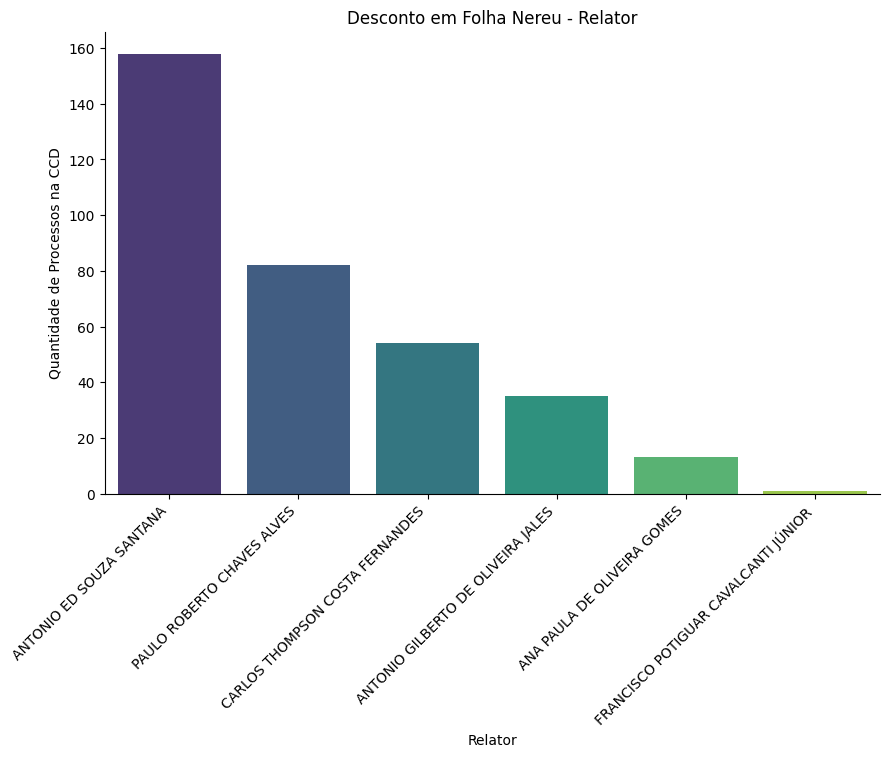

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(data=nereu_relator, x='Relator', y='Quantidade', palette='viridis')
plt.xticks(rotation=45, ha='right')
sns.despine(right=True, top=True)
plt.title('Desconto em Folha Nereu - Relator')
plt.xlabel('Relator')
plt.ylabel('Quantidade de Processos na CCD')
plt.show()

In [38]:
graph_debitos = debitos_ed.groupby('tipo_multa').agg({'valor_multa': 'sum', 'numero_processo': 'count'}).reset_index()

In [39]:
pd.options.display.float_format = '{:,.2f}'.format

In [40]:
graph_debitos

,tipo_multa,valor_multa,numero_processo
0,Multa,"1,265,723.82",96
1,Multa Cominatória,"806,245.66",66


/tmp/ipykernel_92133/4127177992.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=graph_debitos, x='tipo_multa', y='valor_multa', palette='viridis')


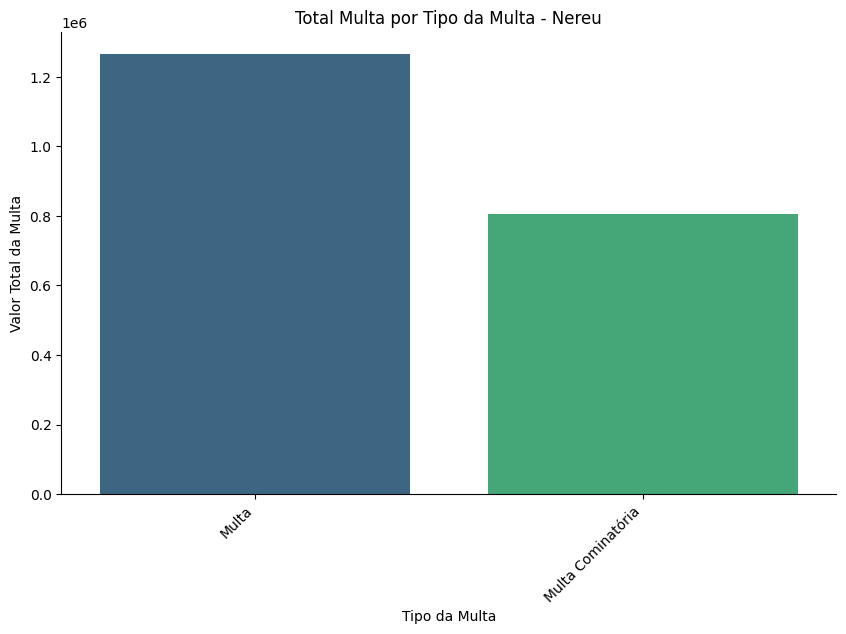

In [41]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=graph_debitos, x='tipo_multa', y='valor_multa', palette='viridis')
plt.xticks(rotation=45, ha='right')
sns.despine(right=True, top=True)
plt.title('Total Multa por Tipo da Multa - Nereu')
plt.xlabel('Tipo da Multa')
plt.ylabel('Valor Total da Multa')
plt.show()

In [42]:
graph_debitos['valor_multa'].sum()

2071969.4764

In [43]:
import locale

# Set locale to Brazilian Portuguese
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

# Sum of valor_multa
total_valor_multa = graph_debitos['valor_multa'].sum()

# Print the sum in BRL currency format
print(locale.currency(total_valor_multa, grouping=True))

R$ 2.071.969,48


## Processos originários

In [24]:
processos_ed['processo'] = processos_ed['numero_processo'].astype(str) + '/' + processos_ed['ano_processo'].astype(str)

/tmp/ipykernel_92133/475517431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processos_ed['processo'] = processos_ed['numero_processo'].astype(str) + '/' + processos_ed['ano_processo'].astype(str)


In [97]:
sql_orig = '''
SELECT * FROM 
processo.dbo.Processos pro
WHERE IdProcesso IN ({})
'''
df_orig = pd.read_sql(
    sql_orig.format(','.join(["'{}'".format(i) for i in debitos_ed['id_processo_origem'].unique()])),
    conn
)
df_orig['processo'] = df_orig['numero_processo'].astype(str) + '/' + df_orig['ano_processo'].astype(str)


/tmp/ipykernel_92133/2970968769.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orig = pd.read_sql(


## Processo 3474/2021 - Lista de processos para retirar

In [134]:

df_planilha_1 = pd.read_excel('docs/planilha_processos_nereu_cut.xlsx', sheet_name='Table 1')
df_planilha_2 = pd.read_excel('docs/planilha_processos_nereu_cut.xlsx', sheet_name='Table 2')
df_planilha_3 = pd.read_excel('docs/planilha_processos_nereu_cut.xlsx', sheet_name='Table 3')
df_planilha_4 = pd.read_excel('docs/planilha_processos_nereu_cut.xlsx', sheet_name='Table 4')
df_planilha = pd.concat([df_planilha_1, df_planilha_2, df_planilha_3, df_planilha_4])
df_planilha['Nº do Processo'].fillna('/', inplace=True)
df_planilha['numero_processo'] = df_planilha['Nº do Processo'].apply(lambda x: x.split('/')[0].strip())
df_planilha['ano_processo'] = df_planilha['Nº do Processo'].apply(lambda x: x.split('/')[1].strip())
df_planilha['processo'] = df_planilha['numero_processo'] + '/' + df_planilha['ano_processo']

In [ ]:
def in_processo_3474_2021(processo):
    return 'SIM' if len(df_planilha[df_planilha['processo'].isin([processo])]) else 'NÃO'

debitos_ed['esta_no_processo_3474_2021'] = debitos_ed['processo_origem'].apply(in_processo_3474_2021)
debitos_ed['valor_multa'] = debitos_ed['valor_multa'].apply(lambda x: locale.currency(x, grouping=True, symbol=False))
debitos_ed['data_final_cominatoria'] = pd.to_datetime(debitos_ed['data_final_cominatoria']).dt.strftime('%d/%m/%Y')   

In [139]:
tab_debitos_ed = debitos_ed[['id_debito', 'processo_origem', 'processo_execucao', 'tipo_multa', 'valor_multa', 'data_final_cominatoria', 'esta_no_processo_3474_2021']]

In [142]:
tab_debitos_ed.to_excel('docs/debitos_ed.xlsx', index=False)

## Checar Informação Consultoria Jurídica

In [29]:
processos_ed['processo'] = processos_ed['numero_processo'].astype(str) + '/' + processos_ed['ano_processo'].astype(str)

/tmp/ipykernel_16993/475517431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processos_ed['processo'] = processos_ed['numero_processo'].astype(str) + '/' + processos_ed['ano_processo'].astype(str)


In [140]:
sql_informacoes = '''
SELECT *
FROM vw_ata_informacao
WHERE CONCAT(numero_processo, '/', ano_processo) IN ({})
'''

df_informacoes = pd.read_sql(sql_informacoes.format(','.join([f"'{x}'" for x in debitos_ed['processo_origem'].unique()])), conn)

/tmp/ipykernel_92133/3337949659.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_informacoes = pd.read_sql(sql_informacoes.format(','.join([f"'{x}'" for x in debitos_ed['processo_origem'].unique()])), conn)


In [141]:
df_informacoes[df_informacoes.setor == 'CONJU']

,setor,numero_processo,ano_processo,ordem,data_resumo,resumo,sigilo,usuario,data_ultima_atualizacao,informacao_efetuada_por,...,Inativa,DataPublicacao,IdInformacaoSubstituida,UsuarioInformacaoSubstituida,DataInformacaoSubstituida,IdTipoParecer,Observacao,IdProcesso,E_Relatorio_Inicial,E_Relatorio_Auditoria


## Informação Processo 000096/2022